Running Fama-French 3-Factor Analysis for AAPL
Period: 2020-01-01 to 2024-01-01

1. Downloading Fama-French factor data...
2. Downloading stock data...
YF.download() has changed argument auto_adjust default to True
Error downloading AAPL data: 'Adj Close'
Using simulated stock data instead...
3. Running Fama-French regression...
4. Analyzing results...

FAMA-FRENCH 3-FACTOR MODEL RESULTS FOR AAPL

Regression Statistics:
R-squared: 0.0027
Adjusted R-squared: -0.0003
F-statistic: 0.91
Prob (F-statistic): 4.35e-01
Number of observations: 1006

Coefficients:
Alpha (Jensen's Alpha): -0.000026 (0.9674)
  → Not Significant, suggesting neutral performance relative to the model

Beta (Market Factor): 0.0615 (0.1571)
  → Stock is less volatile than the market

SMB (Size Factor): -0.0950 (0.2494)
  → Size Factor Not Significant

HML (Value Factor): 0.0059 (0.9072)
  → Value Factor Not Significant

5. Creating visualizations...


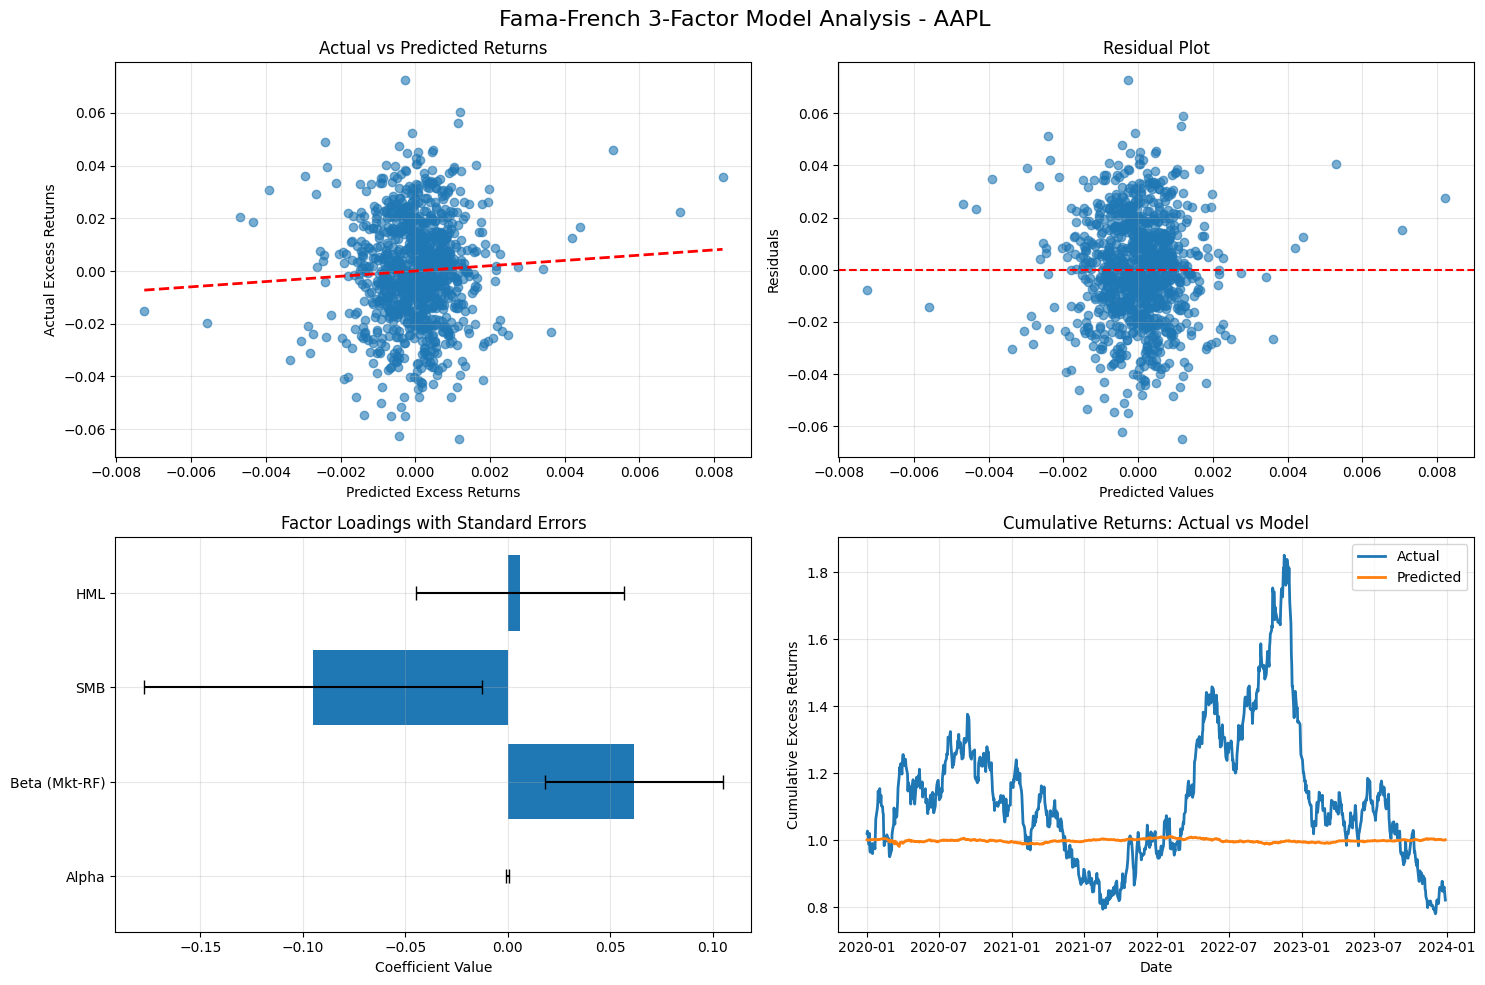


Detailed Regression Output:
                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9110
Date:                Tue, 29 Jul 2025   Prob (F-statistic):              0.435
Time:                        20:55:50   Log-Likelihood:                 2516.8
No. Observations:                1006   AIC:                            -5026.
Df Residuals:                    1002   BIC:                            -5006.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.561e-05  

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import io

def get_ff_factors():
    """
    Download Fama-French 3-Factor data from Kenneth French's website
    """
    # URL for Fama-French 3-Factor daily data
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    
    try:
        # Download and read the data
        response = requests.get(url)
        
        # Read the CSV from the zip file
        from zipfile import ZipFile
        with ZipFile(io.BytesIO(response.content)) as zip_file:
            csv_file = zip_file.namelist()[0]
            with zip_file.open(csv_file) as file:
                # Read the data, skipping the header rows
                df = pd.read_csv(file, skiprows=3)
        
        # Clean the data
        df = df[df.iloc[:, 0].astype(str).str.isdigit()]  # Keep only rows with valid dates
        df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
        
        # Convert date column
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
        df.set_index('Date', inplace=True)
        
        # Convert percentages to decimals
        for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
            df[col] = pd.to_numeric(df[col], errors='coerce') / 100
        
        return df.dropna()
    
    except Exception as e:
        print(f"Error downloading FF factors: {e}")
        print("Using simulated data instead...")
        return create_simulated_ff_data()

def create_simulated_ff_data():
    """
    Create simulated Fama-French factor data for demonstration
    """
    dates = pd.date_range(start='2020-01-01', end='2024-01-01', freq='D')
    dates = dates[dates.weekday < 5]  # Remove weekends
    
    np.random.seed(42)
    n = len(dates)
    
    # Simulate factor returns (daily)
    mkt_rf = np.random.normal(0.0005, 0.012, n)  # Market premium
    smb = np.random.normal(0.0001, 0.005, n)     # Size factor
    hml = np.random.normal(0.0002, 0.006, n)     # Value factor
    rf = np.full(n, 0.00008)                     # Risk-free rate (~2% annual)
    
    df = pd.DataFrame({
        'Mkt-RF': mkt_rf,
        'SMB': smb,
        'HML': hml,
        'RF': rf
    }, index=dates)
    
    return df

def get_stock_data(ticker, start_date, end_date):
    """
    Download stock price data and calculate returns
    """
    try:
        stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if stock.empty:
            raise ValueError(f"No data found for {ticker}")
        
        # Calculate daily returns
        stock['Returns'] = stock['Adj Close'].pct_change()
        return stock['Returns'].dropna()
    
    except Exception as e:
        print(f"Error downloading {ticker} data: {e}")
        print("Using simulated stock data instead...")
        return create_simulated_stock_data(start_date, end_date)

def create_simulated_stock_data(start_date, end_date):
    """
    Create simulated stock return data
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = dates[dates.weekday < 5]  # Remove weekends
    
    np.random.seed(123)
    # Simulate AAPL-like returns with some correlation to market
    returns = np.random.normal(0.001, 0.02, len(dates))
    
    return pd.Series(returns, index=dates, name='Returns')

def run_fama_french_regression(stock_returns, ff_factors):
    """
    Run Fama-French 3-Factor regression
    """
    # Merge stock returns with FF factors
    data = pd.merge(stock_returns, ff_factors, left_index=True, right_index=True, how='inner')
    
    # Calculate excess returns (stock return - risk-free rate)
    data['Excess_Return'] = data['Returns'] - data['RF']
    
    # Prepare regression data
    y = data['Excess_Return']
    X = data[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)  # Add intercept
    
    # Run regression
    model = sm.OLS(y, X).fit()
    
    return model, data

def plot_results(model, data, ticker):
    """
    Create visualizations of the regression results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Fama-French 3-Factor Model Analysis - {ticker}', fontsize=16)
    
    # Plot 1: Actual vs Predicted returns
    predicted = model.fittedvalues
    actual = data['Excess_Return']
    
    axes[0, 0].scatter(predicted, actual, alpha=0.6)
    axes[0, 0].plot([predicted.min(), predicted.max()], 
                    [predicted.min(), predicted.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Predicted Excess Returns')
    axes[0, 0].set_ylabel('Actual Excess Returns')
    axes[0, 0].set_title('Actual vs Predicted Returns')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    residuals = model.resid
    axes[0, 1].scatter(predicted, residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Factor loadings
    factor_names = ['Alpha', 'Beta (Mkt-RF)', 'SMB', 'HML']
    coefficients = model.params
    std_errors = model.bse
    
    y_pos = np.arange(len(factor_names))
    axes[1, 0].barh(y_pos, coefficients, xerr=std_errors, capsize=5)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(factor_names)
    axes[1, 0].set_xlabel('Coefficient Value')
    axes[1, 0].set_title('Factor Loadings with Standard Errors')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Cumulative returns comparison
    cumulative_actual = (1 + data['Excess_Return']).cumprod()
    cumulative_predicted = (1 + predicted).cumprod()
    
    axes[1, 1].plot(cumulative_actual.index, cumulative_actual, label='Actual', linewidth=2)
    axes[1, 1].plot(cumulative_predicted.index, cumulative_predicted, label='Predicted', linewidth=2)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Cumulative Excess Returns')
    axes[1, 1].set_title('Cumulative Returns: Actual vs Model')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def interpret_results(model, ticker):
    """
    Interpret the regression results
    """
    print(f"\n{'='*60}")
    print(f"FAMA-FRENCH 3-FACTOR MODEL RESULTS FOR {ticker}")
    print(f"{'='*60}")
    
    print(f"\nRegression Statistics:")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.2f}")
    print(f"Prob (F-statistic): {model.f_pvalue:.2e}")
    print(f"Number of observations: {model.nobs:.0f}")
    
    print(f"\nCoefficients:")
    coeffs = model.params
    pvalues = model.pvalues
    
    print(f"Alpha (Jensen's Alpha): {coeffs['const']:.6f} ({pvalues['const']:.4f})")
    if pvalues['const'] < 0.05:
        alpha_sig = "significant"
        alpha_interp = "outperforming" if coeffs['const'] > 0 else "underperforming"
    else:
        alpha_sig = "not significant"
        alpha_interp = "neutral performance"
    
    print(f"  → {alpha_sig.title()}, suggesting {alpha_interp} relative to the model")
    
    print(f"\nBeta (Market Factor): {coeffs['Mkt-RF']:.4f} ({pvalues['Mkt-RF']:.4f})")
    if coeffs['Mkt-RF'] > 1:
        beta_interp = "more volatile than the market"
    elif coeffs['Mkt-RF'] < 1:
        beta_interp = "less volatile than the market"
    else:
        beta_interp = "similar volatility to the market"
    print(f"  → Stock is {beta_interp}")
    
    print(f"\nSMB (Size Factor): {coeffs['SMB']:.4f} ({pvalues['SMB']:.4f})")
    if pvalues['SMB'] < 0.05:
        if coeffs['SMB'] > 0:
            smb_interp = "behaves like a small-cap stock"
        else:
            smb_interp = "behaves like a large-cap stock"
    else:
        smb_interp = "size factor not significant"
    print(f"  → {smb_interp.title()}")
    
    print(f"\nHML (Value Factor): {coeffs['HML']:.4f} ({pvalues['HML']:.4f})")
    if pvalues['HML'] < 0.05:
        if coeffs['HML'] > 0:
            hml_interp = "behaves like a value stock"
        else:
            hml_interp = "behaves like a growth stock"
    else:
        hml_interp = "value factor not significant"
    print(f"  → {hml_interp.title()}")
    
    print(f"\n{'='*60}")

# Main execution
if __name__ == "__main__":
    # Parameters
    ticker = "AAPL"
    start_date = "2020-01-01"
    end_date = "2024-01-01"
    
    print(f"Running Fama-French 3-Factor Analysis for {ticker}")
    print(f"Period: {start_date} to {end_date}")
    
    # Download data
    print("\n1. Downloading Fama-French factor data...")
    ff_factors = get_ff_factors()
    
    print("2. Downloading stock data...")
    stock_returns = get_stock_data(ticker, start_date, end_date)
    
    # Run regression
    print("3. Running Fama-French regression...")
    model, data = run_fama_french_regression(stock_returns, ff_factors)
    
    # Display results
    print("4. Analyzing results...")
    interpret_results(model, ticker)
    
    # Create plots
    print("5. Creating visualizations...")
    plot_results(model, data, ticker)
    
    # Display detailed regression output
    print("\nDetailed Regression Output:")
    print(model.summary())